## Assignment 01. Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [2]:
try:
    data = pd.read_csv('https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

In [3]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [4]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [6]:
# task: preprocess each comment in train and test
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()
texts_train = [preprocess(line) for line in texts_train] #<YOUR CODE>
texts_test = [preprocess(line) for line in texts_test]#<YOUR CODE>

In [7]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [8]:
from collections import OrderedDict
from sklearn.base import TransformerMixin
from typing import List, Union
import numpy as np


from collections import Counter

class BoW(TransformerMixin):
    """
    Bag of words tranformer class
    
    check out:
    https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html
    to know about TransformerMixin class
    """

    def __init__(self, k: int):
        """
        :param k: number of most frequent tokens to use
        """
        self.k = k
        # list of k most frequent tokens
        self.bow = None

    def fit(self, X: np.ndarray, y=None):
        """
        :param X: array of texts to be trained on
        """
        # task: find up to self.k most frequent tokens in texts_train,
        # sort them by number of occurences (highest first)
        # store most frequent tokens in self.bow
        token_counts = Counter()
        for text in texts_train:
            token_counts.update(text.split(" "))
        bow = token_counts.most_common(self.k)        
        key = [i[0] for i in bow]
        self.bow = key

        # fit method must always return self
        return self.bow

    def _text_to_bow(self, text: str) -> np.ndarray:
        """
        convert text string to an array of token counts. Use self.bow.
        :param text: text to be transformed
        :return bow_feature: feature vector, made by bag of words
        """
        result = []
        te = text.split(" ")
        for a in self.bow:
          m = te.count(a)
          result.append(m)
        return np.array(result, "float32")

    def transform(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        :param X: array of texts to transform
        :return: array of transformed texts
        """
        assert self.bow is not None
        return np.stack([self._text_to_bow(text) for text in X])

    def get_vocabulary(self) -> Union[List[str], None]:
        return self.bow

In [9]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

#<YOUR CODE>
bow = BoW(k)
bow.fit(texts_train)

print('example features:', sorted(bow.get_vocabulary())[::100])

example features: ['!', '.,', '1st', '7094', 'accepted', 'agenda', 'anonymous', 'aside', 'barnstar', 'bitch', 'bryant', 'cd', 'civility', 'compounding', 'convinced', 'cursed', 'demonizing', 'disadvantages', 'dubious', 'empty', 'example', 'fault', 'fool', 'gallo', 'graduation', 'haven', 'hoops', 'improving', 'interests', 'jpg', 'late', 'listen', 'mangojuice', 'mexican', 'move', 'niederlandish', 'offended', 'paraded', 'picked', 'power', 'props', 'rape', 'releases', 'revealed', 'sanchez', 'sexuality', 'size', 'speak', 'strawberry', 'surveys', 'terrorist', 'tits', 'turned', 'upload', 'voted', 'whore', 'www', 'ல']


In [10]:
X_train_bow = bow.transform(texts_train)
X_test_bow = bow.transform(texts_test)

In [11]:
# Small check that everything is done properly
bow_vocabulary = bow.get_vocabulary()
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [12]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

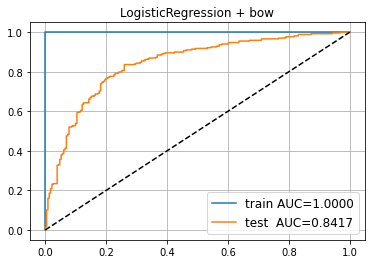

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title("LogisticRegression + bow")
plt.grid()

In [14]:
import numpy as np
from matplotlib import pyplot as plt


def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [16]:
model = nn.Sequential()
### YOUR CODE HERE

model.add_module('l1', nn.Linear(5736,  2))

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [17]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [18]:
opt = torch.optim.Adam(model.parameters(), lr=0.01) ### YOUR CODE HERE

In [19]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

In [20]:
X_train_bow_torch = torch.tensor(X_train_bow, device=device)### YOUR CODE HERE
X_test_bow_torch = torch.tensor(X_test_bow, device=device)### YOUR CODE HERE

In [21]:
y_train_torch = torch.tensor( y_train, device=device)### YOUR CODE HERE
y_test_torch = torch.tensor( y_test, device=device)### YOUR CODE HERE

Let's test that everything is fine

In [22]:
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [23]:
loss

tensor(0.7528, grad_fn=<NllLossBackward0>)

In [24]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [25]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)### YOUR CODE

        # compute loss, just like before
        ### YOUR CODE
        loss = loss_function(y_predicted, y_batch)


        # compute gradients
        ### YOUR CODE
        loss.backward()

        # Adam step
        ### YOUR CODE
        opt.step()

        # clear gradients
        ### YOUR CODE
        opt.zero_grad()


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            predictions_val = []
            acc_score_val = []

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

In [26]:
lr_scheduler = StepLR(opt, step_size=30, gamma=0.1)

In [27]:
y_train_torch.shape

torch.Size([500])

In [28]:
y_test_torch.shape

torch.Size([500])

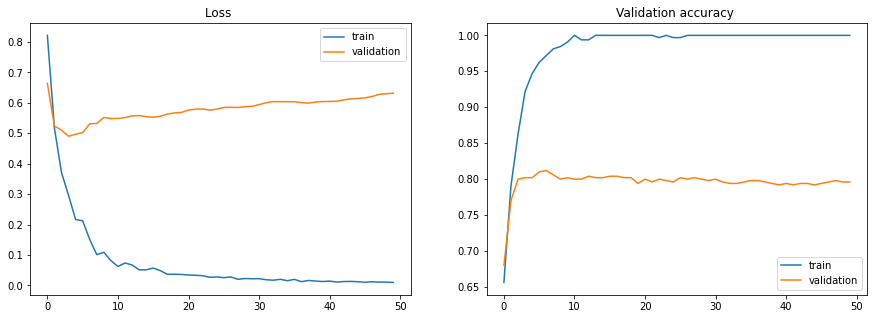

Sequential(
  (l1): Linear(in_features=5736, out_features=2, bias=True)
)

In [29]:
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

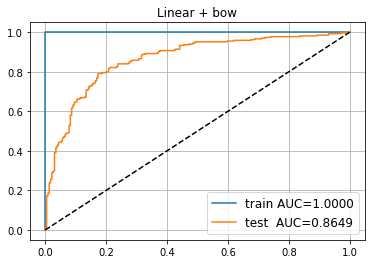

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title("Linear + bow")
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [ ]:
# Your beautiful code here

In [31]:
mask_5000 = torch.arange(0,5000)
mask_5000 = mask_5000.to(device)
mask_5000

tensor([   0,    1,    2,  ..., 4997, 4998, 4999])

In [32]:
X_train_bow_torch_5000 = torch.index_select(X_train_bow_torch, 1, mask_5000)
X_test_bow_torch_5000 = torch.index_select(X_test_bow_torch, 1, mask_5000)
y_test_torch_5000 = y_test_torch[:5000]
y_train_torch_5000 = y_test_torch[:5000]

In [33]:
print(X_train_bow_torch_5000.shape)
print(X_test_bow_torch_5000.shape)

torch.Size([500, 5000])
torch.Size([500, 5000])


In [34]:
model_5000 = nn.Sequential()

model_5000.add_module('l1', nn.Linear(5000, 2))
model_5000.to(device);

In [35]:
opt_5000 = torch.optim.Adam(model_5000.parameters(), lr=0.05) ### YOUR CODE HERE
lr_scheduler_5000 = StepLR(opt_5000, step_size=30, gamma=0.1)

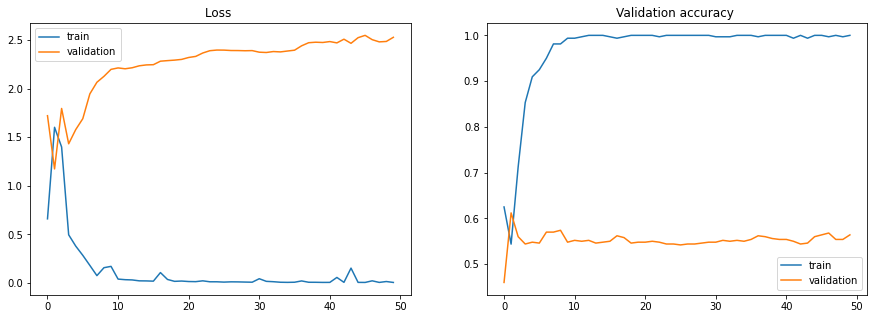

Sequential(
  (l1): Linear(in_features=5000, out_features=2, bias=True)
)

In [36]:
train_model(model_5000, opt_5000, lr_scheduler_5000, X_train_bow_torch_5000, y_train_torch_5000, X_test_bow_torch_5000, y_test_torch_5000)

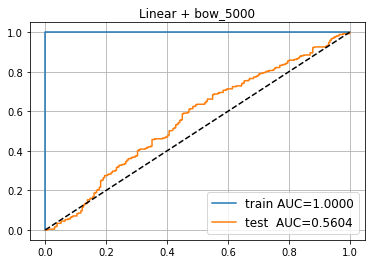

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch_5000, y_train_torch_5000, model_5000),
    ('test ', X_test_bow_torch_5000, y_test_torch_5000, model_5000)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title("Linear + bow_5000")
plt.grid()

In [38]:
mask_4000 = torch.arange(0,4000)
mask_4000 = mask_4000.to(device)
X_train_bow_torch_4000 = torch.index_select(X_train_bow_torch, 1, mask_4000)
X_test_bow_torch_4000 = torch.index_select(X_test_bow_torch, 1, mask_4000)
y_test_torch_4000 = y_test_torch[:4000]
y_train_torch_4000 = y_train_torch[:4000]

In [39]:
print(X_train_bow_torch_4000.shape)
print(X_test_bow_torch_4000.shape)

torch.Size([500, 4000])
torch.Size([500, 4000])


In [40]:
model_4000 = nn.Sequential()

model_4000.add_module('l1', nn.Linear(4000,  2))
model_4000.to(device);

In [41]:
opt_4000 = torch.optim.Adam(model_4000.parameters(), lr=0.01) ### YOUR CODE HERE
lr_scheduler_4000 = StepLR(opt_4000, step_size=30, gamma=0.1)

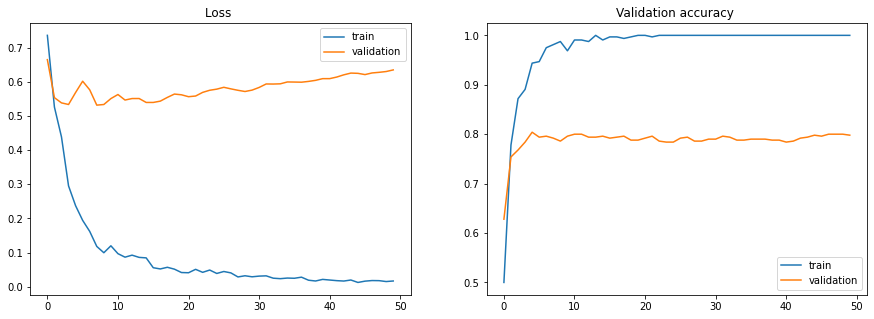

Sequential(
  (l1): Linear(in_features=4000, out_features=2, bias=True)
)

In [42]:
train_model(model_4000, opt_4000, lr_scheduler_4000, X_train_bow_torch_4000, y_train_torch_4000, X_test_bow_torch_4000, y_test_torch)

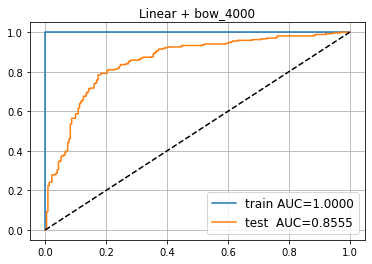

In [43]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch_4000, y_train_torch_4000, model_4000),
    ('test ', X_test_bow_torch_4000, y_test_torch_4000, model_4000)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title("Linear + bow_4000")
plt.grid()

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [44]:
class TfIdf(TransformerMixin):
    """
    Tf-Idf tranformer class
    if you have troubles implementing Tf-Idf, check out:
    https://streamsql.io/blog/tf-idf-from-scratch
    """

    def __init__(self, k: int = None, normalize: bool = False):
        """
        :param k: number of most frequent tokens to use
        if set k equals None, than all words in train must be considered
        :param normalize: if True, you must normalize each data sample
        after computing tf-idf features
        """
        self.k = k
        self.normalize = normalize

        # self.idf[term] = log(total # of documents / # of documents with term in it)
        self.idf = OrderedDict()        

    def fit(self, X: np.ndarray, y=None):
        """
        :param X: array of texts to be trained on
        """
        # fit method must always return self
        token_counts = Counter()
        for text in texts_train:
            token_counts.update(text.split(" "))
        token_most_common = token_counts.most_common(self.k)  
        self.idf = dict(token_most_common)
        return self

    def _text_to_tf_idf(self, text: str) -> np.ndarray:
        """
        convert text string to an array tf-idfs.
        *Note* don't forget to normalize, when self.normalize == True
        :param text: text to be transformed
        :return tf_idf: tf-idf features
        """        
        result = []
        te = text.split(" ")
        for a in self.idf:
          m = te.count(a) * np.log(k / (self.idf[a] + 1))
          if self.normalize:
            m /= len(te) 
          result.append(m)
        return np.array(result, "float32")

    def transform(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        :param X: array of texts to transform
        :return: array of transformed texts
        """
        assert self.idf is not None
        return np.stack([self._text_to_tf_idf(text) for text in X])

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [45]:
k = min(10000, len(set(' '.join(texts_train).split())))

tfidf= TfIdf(k)
tfidf.fit(texts_train)

In [46]:
X_train_tfidf = tfidf.transform(texts_train)
X_test_tfidf = tfidf.transform(texts_test)

In [47]:
X_train_tfidf_torch = torch.tensor(X_train_tfidf, dtype=torch.float , device=device) ### YOUR CODE HERE
X_test_tfidf_torch = torch.tensor(X_test_tfidf, dtype=torch.float , device=device)### YOUR CODE HERE

In [48]:
X_test_tfidf_torch.shape

torch.Size([500, 5736])

In [49]:
from sklearn.linear_model import LogisticRegression
tfidf_model = LogisticRegression().fit(X_train_tfidf, y_train)

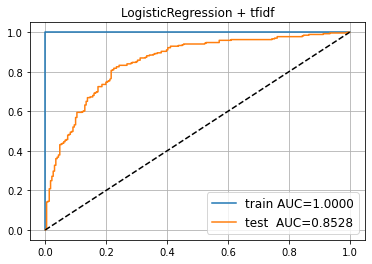

In [50]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_tfidf, y_train, tfidf_model),
    ('test ', X_test_tfidf, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title("LogisticRegression + tfidf")
plt.grid()

In [51]:
model_ = nn.Sequential()

model_.add_module('l1', nn.Linear(5736, 2))
model_.to(device);

In [52]:
opt_ = torch.optim.Adam(model_.parameters(), lr=0.01)
lr_scheduler_ = StepLR(opt_, step_size=30, gamma=0.1)

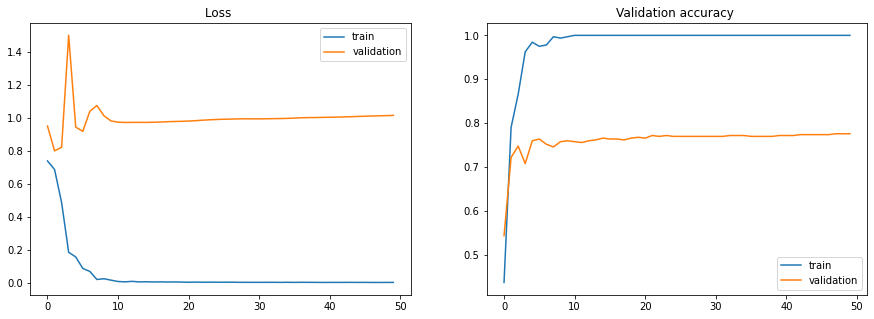

Sequential(
  (l1): Linear(in_features=5736, out_features=2, bias=True)
)

In [53]:
train_model(model_, opt_, lr_scheduler_, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch)

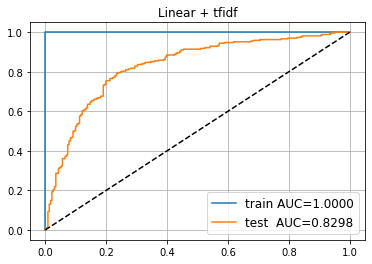

In [54]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train_torch, model_),
    ('test ', X_test_tfidf_torch, y_test_torch, model_)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title("Linear + tfidf")
plt.grid()

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [55]:
from sklearn.naive_bayes import MultinomialNB

clf_bow = MultinomialNB()
clf_bow.fit(X_train_bow_torch, y_train_torch)

MultinomialNB()

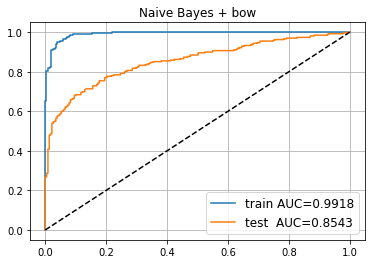

In [56]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train_torch, clf_bow),
    ('test ', X_test_bow_torch, y_test_torch, clf_bow)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title("Naive Bayes + bow")
plt.grid()

In [57]:
from sklearn.naive_bayes import MultinomialNB

clf_tfidf = MultinomialNB()
clf_tfidf.fit(X_train_tfidf_torch, y_train_torch)

MultinomialNB()

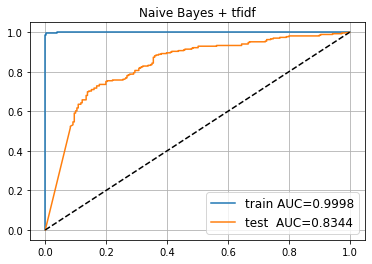

In [58]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train_torch, clf_tfidf),
    ('test ', X_test_tfidf_torch, y_test_torch, clf_tfidf)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title("Naive Bayes + tfidf")
plt.grid()

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

_Your beautiful thoughts here_

Результаты Naive Bayes с алгоритмом BOW (AUC=0.8543) показали результат лучше на 2 процента на тестовой выборке, чем результаты Naive Bayes с алгоритмом TF-iDF(AUC=0.8344). Возможноо имеет место переобучение.

Результаты Logistic Regression с алгоритмом TF-iDF(AUC=0.8528) показали результат лучше на 1 процент на тестовой выборке, чем результаты Logistic Regression с алгоритмом BOW (AUC=0.8417). 

Результаты Logistic Regression и Naive Bayes отличаются не значительно


### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [ ]:
# Your beautiful code here

In [59]:
#twitter
from gensim.models import Word2Vec
import gensim.downloader as api

model = api.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


In [60]:
def to_vectors(model, texts):
  vectors = []
  for text in texts:
    vector = []
    for word in text.split():
      try:
        c = model.get_vector(word)
      except KeyError:
        c = np.zeros((100,), dtype='float32')
      vector.append(c)
    vectors.append(np.mean(vector, axis= 0))
  return vectors

In [61]:
train_vectors = to_vectors(model, texts_train)
test_vectors = to_vectors(model, texts_test)

In [62]:
X_train_w2v_torch = torch.tensor(train_vectors, device=device)### YOUR CODE HERE
X_test_w2v_torch = torch.tensor(test_vectors, device=device)### YOUR CODE HERE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


In [63]:
from sklearn.linear_model import LogisticRegression
w2v_model = LogisticRegression().fit(X_train_w2v_torch, y_train_torch)

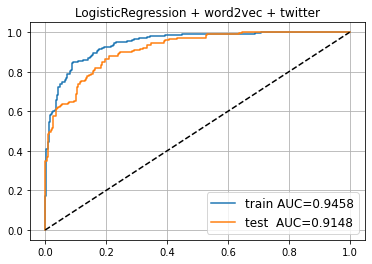

In [64]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_w2v_torch, y_train_torch, w2v_model),
    ('test ', X_test_w2v_torch, y_test_torch, w2v_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title("LogisticRegression + word2vec + twitter")
plt.grid()

In [65]:
#wiki
from gensim.models import Word2Vec
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [66]:
train_vectors = to_vectors(model, texts_train)
test_vectors = to_vectors(model, texts_test)

In [67]:
X_train_w2v_torch = torch.tensor(train_vectors, device=device)### YOUR CODE HERE
X_test_w2v_torch = torch.tensor(test_vectors, device=device)### YOUR CODE HERE

In [68]:
from sklearn.linear_model import LogisticRegression
w2v_model = LogisticRegression().fit(X_train_w2v_torch, y_train_torch)

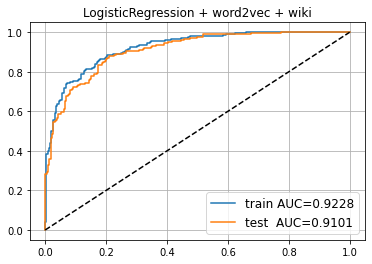

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_w2v_torch, y_train_torch, w2v_model),
    ('test ', X_test_w2v_torch, y_test_torch, w2v_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title("LogisticRegression + word2vec + wiki")
plt.grid()

Применение предобученного word2vec + Logistic Regression(AUC=0.9148) показало результат лучше, чем TF-iDF + Logistic Regression(AUC=0.8528) и BOW + Logistic Regression(AUC=0.8417).

Результаты предобученной модели glove-twitter-100 (AUC=0.9148) оказались лучше, чем glove-wiki-gigaword-100 (AUC=0.9101). Причиной этого может быть схожесть данных исходной задачи и модели  glove-twitter-100 (соцсеть), в отличии от glove-wiki-gigaword-100 (интернет - энциклопедия)